# Project: Bollinger Bands Mean Reversion Strategy

When prices move far from their average (more than a few standard deviations), they tend to revert.
We’ll go long when the price dips below the lower Bollinger Band (oversold) and short when it rises above the upper band (overbought).

We’ll only take Bollinger Band mean reversion signals when the RSI confirms oversold or overbought conditions — improving signal quality and avoiding “catching falling knives.”

## Imports

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import logging
from datetime import datetime

%load_ext autoreload
%autoreload 2

## Data Setup

In [2]:
# Initialize variables
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

ticker, start_date, end_date

('AAPL', '2015-01-01', '2025-11-20')

In [251]:
# Download stock data from YFinance
df = yf.download(ticker, start=start_date, end=end_date)
df = df.xs(ticker, axis=1, level=1)['Close'].to_frame()

df.tail()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2025-11-14,272.410004
2025-11-17,267.459991
2025-11-18,267.440002
2025-11-19,268.559998
2025-11-20,266.250000


## Set Indicators

In [85]:
window = 20 # The number of periods to calculate the moving average over
num_std = 2 # The number of standard deviations from the mean to set upper and lower bounds
rsi_period = 14 # The number of periods to calculate the Relative Strength Index over

In [86]:
df['MA'] = df['Close'].rolling(window).mean() # Moving average
df['STD'] = df['Close'].rolling(window).std() # Standard deviation
df['Upper'] = df['MA'] + num_std * df['STD'] # Upper bound x number of standard deviations from the mean
df['Lower'] = df['MA'] - num_std * df['STD'] # Lower bound x number of standard deviations from the mean

In [87]:
# RSI Calculation

delta = df['Close'].diff() # Change in price from the previous close
gain = np.where(delta > 0, delta, 0) # Positive price movements
loss = np.where(delta < 0, -delta, 0) # Negative price movements
avg_gain = pd.Series(gain).rolling(rsi_period).mean() # The average positive price movement over a rolling window
avg_loss = pd.Series(loss).rolling(rsi_period).mean() # The average negative price movement over a rolling window
rs = (avg_gain / avg_loss).values # Average gain/loss over a rolling window
df['RSI'] = 100 - (100 / (1 + rs)) # Relative Strength Index (RSI > 70 indicates an OVERBOUGHT stock & RSI < 30 indicates an OVERSOLD stock)

df.dropna(inplace=True)
df.head()


,Close,MA,STD,Upper,Lower,RSI
Date,,,,,,
2015-01-30,25.973396,24.528299,0.796547,26.121392,22.935205,58.434364
2015-02-02,26.299282,24.631385,0.885395,26.402175,22.860596,66.039630
2015-02-03,26.303713,24.768834,0.922075,26.612984,22.924684,64.899150
2015-02-04,26.505459,24.916259,0.953298,26.822856,23.009662,66.956274
2015-02-05,26.694643,25.056627,0.999383,27.055393,23.057860,75.500367


## Trading Logic & Backtesting

Conditions:
* Long when price < lower band AND RSI < 30 (oversold)
* Short when price > upper band AND RSI > 70 (overbought)
* Exit when price crosses back towards MA

In [100]:
def bollinger(df,
              investment: float = 100.00,
              exit_method: str = 'bound',
              trade_commission: float = 0.00,
              log_trades: bool = True,
              return_trades: bool = False) -> pd.DataFrame:
    
    '''
        Function to run a full backtest on the bollinger mean reversion & RSI method with optional exit methods
        
        Parameters:
            df_backtest: 
                Pandas DataFrame containing periodic close price data

            exit_method: Optional exit strategies, default = "bound":
                Parameter options:
                    * bound - Exit LONG trades when the price crosses the lower bollinger band from below & Exit SHORT trades when the price crosses the upper bollinger band from above
                    * ma - Exit LONG & SHORT trades when the price touches the moving average
                    * single - Exit position after a single period of trading

            trade_fee: 
                Optional inclusion of trade fee losses

            log_trades, default = True
                Option to write individual trade information to a trade report file

            return_trades, default = False
                Option to return a second dataframe containing trade report data

        Returns:
            pandas DataFrame
    '''

    df_backtest = df.copy()

    df_backtest['BuyHold'] = df_backtest['Close'].pct_change()
    df_backtest['BuyHoldCurve'] = (1 + df_backtest['BuyHold']).cumprod()
    # Monetary returns on initial investment
    df_backtest['BuyHoldValue'] = round((df_backtest['BuyHold'] + 1).fillna(investment).cumprod(),2)

    if exit_method not in ['bound', 'ma', 'single']:
        raise Exception('exit_method must be one of: "bound", "ma", "single"')

    position = 0.0 # 1 = LONG, -1 = SHORT, 0 = FLAT
    # df_backtest['Position'] = position # Initial FLAT (No position)
    trade_num = 0
    last_trade_num = 0
    # df_backtest['Trade_Num'] = trade_num # Track all indivdual trades

    for i in range(1, len(df_backtest)):

        # Previous closing period will signal the current periods position
        prev_price = df_backtest['Close'].iloc[i-1] # Previous closing price
        prev_ma = df_backtest['MA'].iloc[i-1] # Previous closing moving average
        prev_rsi = df_backtest['RSI'].iloc[i-1] # Previous closing RSI
        prev_upper = df_backtest['Upper'].iloc[i-1] # Previous closing upper bollinger limit
        prev_lower = df_backtest['Lower'].iloc[i-1] # Previous closing lower bollinger limit

        if position != 0:
            last_trade_num = trade_num

        # Only hold position for a single period of trading
        if exit_method == 'single':
            position = 0

        # ENTRY RULES
        if position == 0: # FLAT
            if prev_price < prev_lower and prev_rsi < 30: # If price crosses the lower band & stock is undersold
                position = 1 # Open a LONG position
                trade_num = last_trade_num + 1 # Flag new trade position
            elif prev_price > prev_upper and prev_rsi > 70: # If price crosses the upper band & stock is oversold
                position = -1 # Open a SHORT position
                trade_num = last_trade_num + 1 # Flag new trade position
        # EXIT RULES
        else:
            match exit_method:
                case 'bound':
                    if position == 1 and prev_price > prev_lower: # If position is LONG and price crosses below the upper bollinger limit
                        position = 0 # Exit LONG position
                        trade_num = 0
                        
                    elif position == -1 and prev_price < prev_upper: # If position is SHORT and price crosses above the lower bollinger limit 
                        position = 0 # Exit SHORT position
                        trade_num = 0

                case 'ma':
                    if position == 1 and prev_price >= prev_ma: #and prev_price > prev_ma:
                        position = 0 # Exit LONG when price crosses below MA
                        trade_num = 0
                    elif position == -1 and prev_price <= prev_ma: #and prev_price < prev_ma:
                        position = 0 # Exit SHORT when price crosses above MA
                        trade_num = 0

        # Period parameters will signal the position for the next trading period
        df_backtest.loc[df_backtest.index[i-1], 'Signal'] = position
        # Indicate whether we are currently in a LONG or SHORT position
        df_backtest.loc[df_backtest.index[i], 'Position'] = float(position)
        # Track trade number
        df_backtest.loc[df_backtest.index[i], 'TradeNum'] = trade_num

    df_backtest['Signal'] = df_backtest['Signal'].fillna(0)
    df_backtest['TradeNum'] = df_backtest['TradeNum'].replace({0: np.nan}).bfill(limit=1) # Backfill 1 period as the trade is entered when signalled
    # Strategy returns before accounting for transaction losses, such as fees and slippage
    df_backtest['StrategyGross'] = df_backtest['Position'] * df_backtest['BuyHold'] # We only benefit from price movements when in position
    # Trade fees are applied on both entry and exit of trades
    df_backtest['TradeFee'] = - abs(df_backtest['Signal'] - df_backtest['Position']) * trade_commission
    # Total strategy returns after accounting for transaction losses
    df_backtest['Strategy'] = (1 + df_backtest['StrategyGross']) * (1 + df_backtest['TradeFee']) - 1
    df_backtest['StrategyCurve'] = (1 + df_backtest['Strategy']).cumprod()
    # Monetary returns on initial investment
    df_backtest['StrategyValue'] = round((df_backtest['Strategy'] + 1).fillna(investment).cumprod(),2)

    df_backtest['TransactionCost'] = round(df_backtest['TradeFee'] * df_backtest['StrategyValue'].shift(),2)
    
    return df_backtest

# bollinger(df, exit_method='bound', trade_commission=0, investment=100)

In [101]:
# Runing a backtest on the bollinger method using a bound exit strategy, not accounting for any trading fee losses
df_backtest = bollinger(df, exit_method='bound', trade_commission=0.00025)
df_backtest

,Close,MA,STD,Upper,Lower,RSI,BuyHold,BuyHoldCurve,BuyHoldValue,Signal,Position,TradeNum,StrategyGross,TradeFee,Strategy,StrategyCurve,StrategyValue,TransactionCost
Date,,,,,,,,,,,,,,,,,,
2015-01-30,25.973396,24.528299,0.796547,26.121392,22.935205,58.434364,NaN,NaN,100.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,100.00,NaN
2015-02-02,26.299282,24.631385,0.885395,26.402175,22.860596,66.039630,0.012547,1.012547,101.25,0.0,0.0,NaN,0.0,-0.0,0.0,1.000000,100.00,-0.0
2015-02-03,26.303713,24.768834,0.922075,26.612984,22.924684,64.899150,0.000168,1.012717,101.27,0.0,0.0,NaN,0.0,-0.0,0.0,1.000000,100.00,-0.0
2015-02-04,26.505459,24.916259,0.953298,26.822856,23.009662,66.956274,0.007670,1.020485,102.05,0.0,0.0,NaN,0.0,-0.0,0.0,1.000000,100.00,-0.0
2015-02-05,26.694643,25.056627,0.999383,27.055393,23.057860,75.500367,0.007138,1.027769,102.78,0.0,0.0,NaN,0.0,-0.0,0.0,1.000000,100.00,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-13,272.950012,267.093961,5.808409,278.710778,255.477143,72.558644,-0.001901,10.508830,1050.88,0.0,0.0,NaN,-0.0,-0.0,0.0,1.245907,124.59,-0.0
2025-11-14,272.410004,268.112178,4.713296,277.538771,258.685585,60.984026,-0.001978,10.488039,1048.80,0.0,0.0,NaN,-0.0,-0.0,0.0,1.245907,124.59,-0.0
2025-11-17,267.459991,268.385876,4.492599,277.371074,259.400679,47.135420,-0.018171,10.297459,1029.75,0.0,0.0,NaN,-0.0,-0.0,0.0,1.245907,124.59,-0.0


In [90]:
df_trades = pd.read_csv('reports/trade_log.csv', index_col='Trade Num')
df_trades

,EntryDate,ExitDate,Direction,EntryPrice,ExitPrice,GrossReturn,TransactionCost,NetReturn,DurationDays
Trade Num,,,,,,,,,
1,2015-04-28,2015-04-29,Short,29.523457,29.058304,0.015755,0.000158,0.015598,1
2,2015-07-10,2015-07-13,Long,26.835199,27.552618,0.026734,0.000267,0.026467,3
3,2015-08-05,2015-08-06,Long,25.621614,25.791470,0.006629,0.000066,0.006563,1
4,2015-10-26,2015-10-27,Short,26.734406,25.881271,0.031911,0.000319,0.031592,1
5,2015-12-16,2015-12-17,Long,24.912066,25.103714,0.007693,0.000077,0.007616,1
...,...,...,...,...,...,...,...,...,...
96,2025-03-11,2025-03-17,Long,226.704773,212.762451,-0.061500,0.000615,-0.062115,6
97,2025-04-08,2025-04-10,Long,180.841614,198.172348,0.095834,0.000958,0.094875,2
98,2025-07-03,2025-07-08,Short,211.993668,209.508896,0.011721,0.000117,0.011604,5


In [105]:
def get_trade_stats(data):

    df_group = data.copy()

    df_group['StrategyValueShifted'] = df_group['StrategyValue'].shift()

    df_group = df_group.reset_index().groupby('TradeNum').agg({'Date': ['first', 'last'],
                                                               'Position': 'last',
                                                               'Close': ['first', 'last'],
                                                               'StrategyCurve': 'last',
                                                               'TransactionCost': 'sum',
                                                               'StrategyValueShifted': 'first',
                                                               'StrategyValue': 'last'})

    df_group.columns=['EntryDate','ExitDate','Direction','EntryPrice','ExitPrice','NetReturn','TransactionFee', 'InvestmentOpen', 'InvestmentClose']
    df_group['PnL'] = df_group['InvestmentClose'] - df_group['InvestmentOpen']
    df_group['DurationDays'] = (df_group['ExitDate'] - df_group['EntryDate']).dt.days
    df_group['Direction'] = df_group['Direction'].replace({1:'Long', -1:'Short'})
    df_group['NetReturn'] = df_group['NetReturn'].pct_change().fillna(df_group['NetReturn'].iloc[0] - 1) + 1
    
    return df_group
    # return data

get_trade_stats(df_backtest)

,EntryDate,ExitDate,Direction,EntryPrice,ExitPrice,NetReturn,TransactionFee,InvestmentOpen,InvestmentClose,PnL,DurationDays
TradeNum,,,,,,,,,,,
1.0,2015-04-27,2015-04-28,Short,29.523455,29.058294,1.015248,-0.04,100.00,101.52,1.52,1
2.0,2015-07-09,2015-07-10,Long,26.835201,27.552622,1.026221,-0.06,101.52,104.19,2.67,1
3.0,2015-08-04,2015-08-05,Long,25.621611,25.791475,1.006126,-0.06,104.19,104.83,0.64,1
4.0,2015-10-23,2015-10-26,Short,26.734409,25.881271,1.031396,-0.06,104.83,108.12,3.29,3
5.0,2015-12-15,2015-12-16,Long,24.912062,25.103716,1.007189,-0.06,108.12,108.89,0.77,1
...,...,...,...,...,...,...,...,...,...,...,...
96.0,2025-03-10,2025-03-14,Long,226.704773,212.762466,0.938031,-0.06,118.03,110.72,-7.31,4
97.0,2025-04-07,2025-04-09,Long,180.841614,198.172348,1.095286,-0.06,110.72,121.27,10.55,2
98.0,2025-07-02,2025-07-07,Short,211.993668,209.508896,1.011039,-0.06,121.27,122.60,1.33,5


## Performance Evaluation

In [107]:
def performance_metrics(df_performance,
                        performance_on: str | list[str] = ['Strategy', 'BuyHold'],
                        return_dict: bool = False) -> pd.DataFrame | dict:

    '''
    Function to evaluate backtested performance on given strategies
    '''

    performance_dict = {}

    if type(performance_on) == str:
        performance_on = [performance_on]

    for method in performance_on:

        strategy = df_performance[method]
        strat_total_return = df_performance[f'{method}Curve'].iloc[-1] - 1
        strat_cagr = (df_performance[f'{method}Curve'].iloc[-1]) ** (252 / len(df_performance)) - 1
        strat_risk = strategy.std() * np.sqrt(252)
        strat_return = strategy.mean() * 252
        strat_sharpe = strat_return / strat_risk
        strat_max_dd = (df_performance[f'{method}Curve'].cummax() - df_performance[f'{method}Curve']).max()

        performance_dict[method] = {
            'Total Return': f'{strat_total_return:.2%}',
            'Annual Return': round(strat_return,2),
            'Annual Risk': round(strat_risk,2),
            'Sharpe Ratio': round(strat_sharpe, 2),
            'CAGR': f'{strat_cagr:.2%}',
            'Max Drawdown': f'{strat_max_dd:.2%}'
            }
        
    if return_dict:
        return performance_dict
    else:
        return pd.DataFrame.from_dict(performance_dict, orient='Index')

In [108]:
performance_metrics(df_backtest)

,Total Return,Annual Return,Annual Risk,Sharpe Ratio,CAGR,Max Drawdown
Strategy,24.59%,0.02,0.09,0.27,2.06%,18.28%
BuyHold,933.98%,0.26,0.29,0.89,24.17%,331.19%


### Trade Statistics

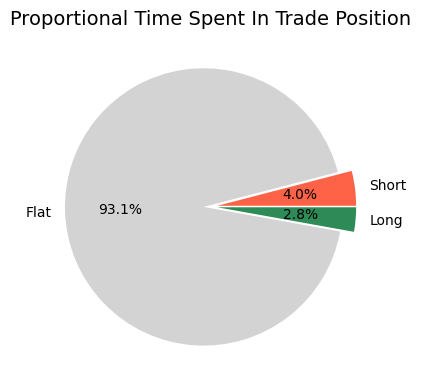

In [115]:
fig, ax = plt.subplots(figsize=(12, 4), tight_layout=True)

ax.set_title('Proportional Time Spent In Trade Position', fontsize=14)
ax.pie(df_backtest.groupby('Position').count()['Close'],
           labels=['Short', 'Flat', 'Long'],
           autopct='%1.1f%%',
           colors=['tomato', 'lightgrey', 'seagreen'],
           explode=[0.05, 0.05, 0.05],
           shadow=False)

plt.show;

In [122]:
df_trades = get_trade_stats(df_backtest)
df_trades

,EntryDate,ExitDate,Direction,EntryPrice,ExitPrice,NetReturn,TransactionFee,InvestmentOpen,InvestmentClose,PnL,DurationDays
TradeNum,,,,,,,,,,,
1.0,2015-04-27,2015-04-28,Short,29.523455,29.058294,1.015248,-0.04,100.00,101.52,1.52,1
2.0,2015-07-09,2015-07-10,Long,26.835201,27.552622,1.026221,-0.06,101.52,104.19,2.67,1
3.0,2015-08-04,2015-08-05,Long,25.621611,25.791475,1.006126,-0.06,104.19,104.83,0.64,1
4.0,2015-10-23,2015-10-26,Short,26.734409,25.881271,1.031396,-0.06,104.83,108.12,3.29,3
5.0,2015-12-15,2015-12-16,Long,24.912062,25.103716,1.007189,-0.06,108.12,108.89,0.77,1
...,...,...,...,...,...,...,...,...,...,...,...
96.0,2025-03-10,2025-03-14,Long,226.704773,212.762466,0.938031,-0.06,118.03,110.72,-7.31,4
97.0,2025-04-07,2025-04-09,Long,180.841614,198.172348,1.095286,-0.06,110.72,121.27,10.55,2
98.0,2025-07-02,2025-07-07,Short,211.993668,209.508896,1.011039,-0.06,121.27,122.60,1.33,5


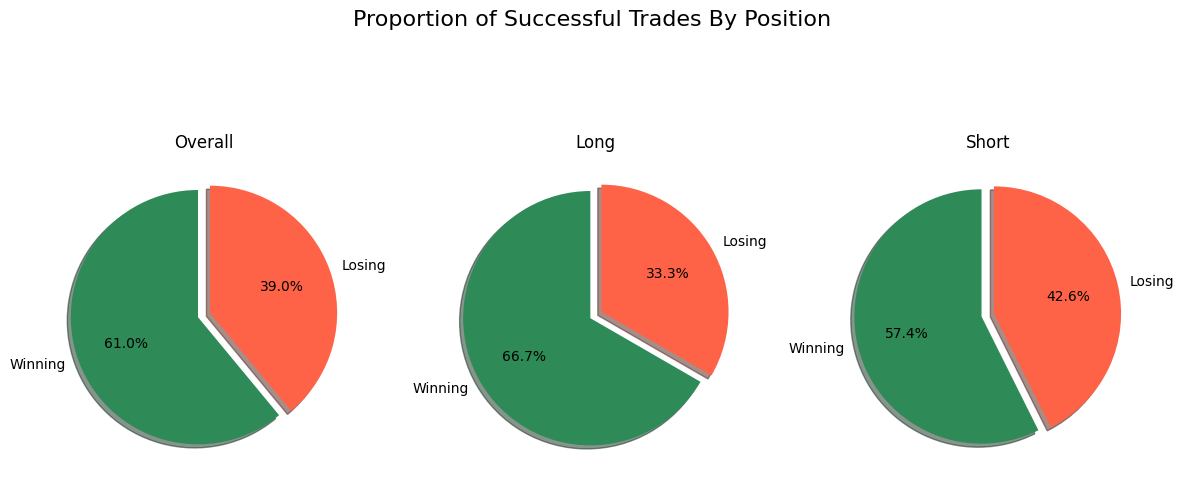

In [123]:
fig, ax = plt.subplots(1, 3, figsize=(12,6), tight_layout=True)

fig.suptitle('Proportion of Successful Trades By Position', fontsize=16)

ax[0].set_title('Overall', fontsize=12)
ax[0].pie((df_trades['NetReturn'] > 1).value_counts(),
           labels=['Winning', 'Losing'],
           autopct='%1.1f%%',
           colors=['seagreen', 'tomato'],
           explode=[0.05, 0.05],
           shadow=True,
           startangle=90)

ax[1].set_title('Long', fontsize=12)
ax[1].pie((df_trades[df_trades['Direction']=='Long']['NetReturn'] > 1).value_counts(),
           labels=['Winning', 'Losing'],
           autopct='%1.1f%%',
           colors=['seagreen', 'tomato'],
           explode=[0.05, 0.05],
           shadow=True,
           startangle=90)

ax[2].set_title('Short', fontsize=12)
ax[2].pie((df_trades[df_trades['Direction']=='Short']['NetReturn'] > 1).value_counts(),
           labels=['Winning', 'Losing'],
           autopct='%1.1f%%',
           colors=['seagreen', 'tomato'],
           explode=[0.05, 0.05],
           shadow=True,
           startangle=90)

plt.show()

## Visualization

### Bollinger Bands Plot With Long/Short Signals

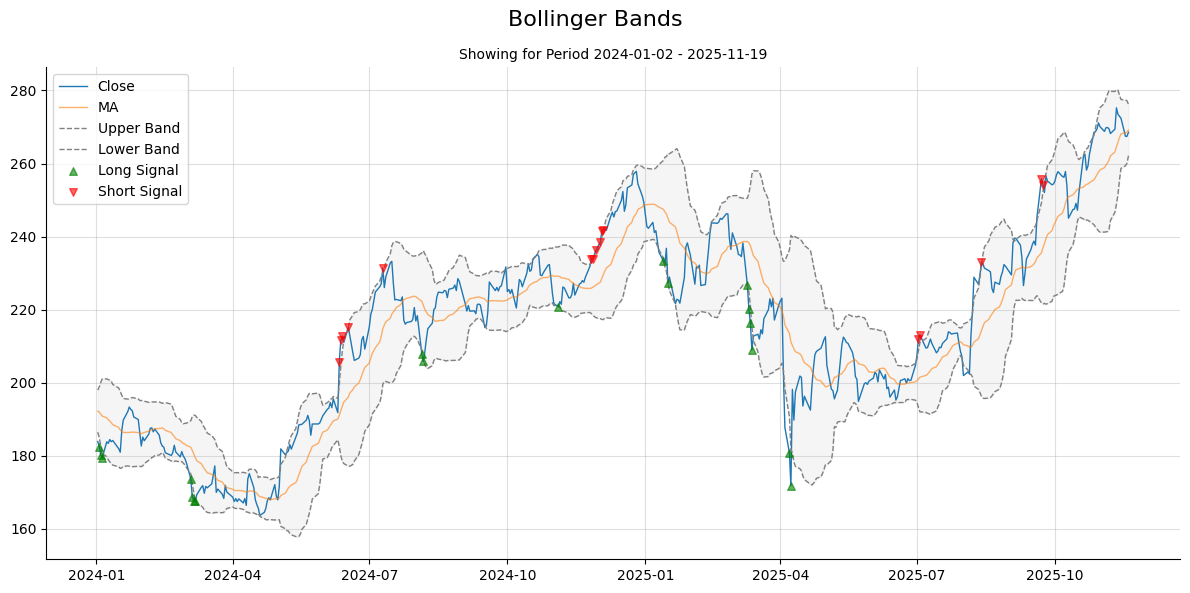

In [124]:
def plot_bands(df):

    fig, ax = plt.subplots(figsize=(12,6), tight_layout=True)
    fig.suptitle(f'Bollinger Bands', fontsize=16)
    ax.set_title(f'Showing for Period {df.index[0].date()} - {df.index[-1].date()}', fontsize=10)

    ax.plot(df['Close'], label = 'Close', linewidth=1)
    ax.plot(df['MA'], label = 'MA', linewidth=1, alpha=0.6)
    ax.plot(df['Upper'], label = 'Upper Band', linestyle='--', color='grey', linewidth=1)
    ax.plot(df['Lower'], label = 'Lower Band', linestyle='--', color='grey', linewidth=1)
    ax.fill_between(df.index, df['Upper'], df['Lower'], color='grey', alpha=0.075)

    ax.scatter(x=df[df['Signal']==1].index, y=df[df['Signal']==1]['Close'].loc[df[df['Signal']==1].index], marker='^', s=30, color='Green', label='Long Signal', zorder=4, alpha=0.6)
    ax.scatter(x=df[df['Signal']==-1].index, y=df[df['Signal']==-1]['Close'].loc[df[df['Signal']==-1].index], marker='v', s=30, color='red', label='Short Signal', zorder=4, alpha=0.6)

    ax.grid(True, alpha=0.4)
    ax.spines[['top', 'right']].set_visible(False)
    ax.legend(loc='best')

    return plt.show()

plot_bands(df_backtest.loc['2024':])

### RSI Plot

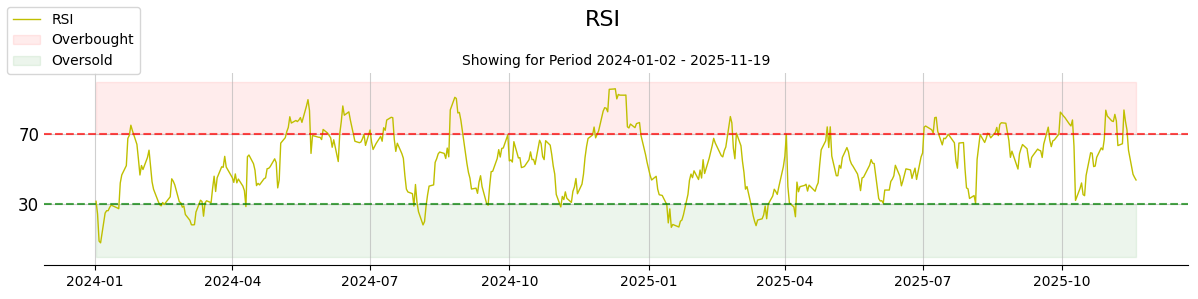

In [125]:
def plot_rsi(df):

    fig, ax = plt.subplots(figsize=(12,3), tight_layout=True)
    fig.suptitle('RSI', fontsize=16)
    ax.set_title(f'Showing for Period {df.index[0].date()} - {df.index[-1].date()}', fontsize=10)
    ax.plot(df['RSI'], label = 'RSI', linewidth=1, color='y')
    ax.axhline(70, color="r", linestyle="--", alpha=0.7)
    ax.axhline(30, color="g", linestyle="--", alpha=0.7)
    ax.fill_between(df.index, 70, 100, color='r', alpha=0.075, label='Overbought')
    ax.fill_between(df.index, 0, 30, color='g', alpha=0.075, label='Oversold')

    ax.grid(True, alpha=0.6)

    ax.spines[['top', 'right', 'left']].set_visible(False)
    fig.legend(loc='outside upper left')
    
    ax.set_yticks([30,70])
    ax.tick_params(axis='y', labelsize=12, length=0)

    return plt.show()

plot_rsi(df_backtest.loc['2024':])


### Strategy vs Buy&Hold

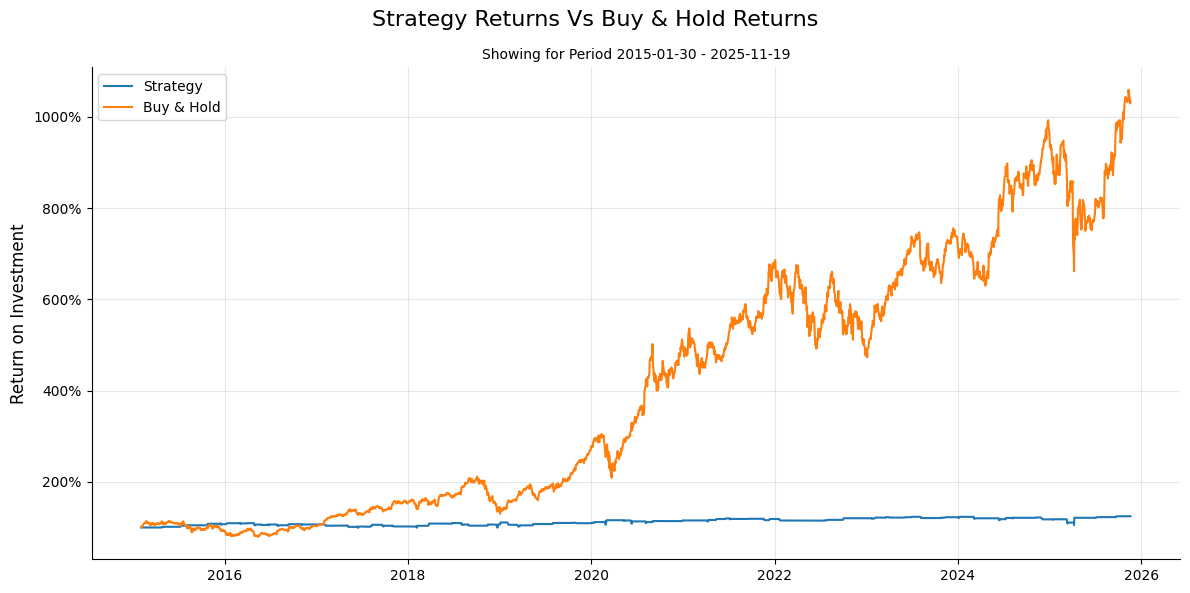

In [140]:
def plot_return_curve(df_curve):

    fig, ax = plt.subplots(figsize=(12,6), tight_layout=True)
    fig.suptitle('Strategy Returns Vs Buy & Hold Returns', fontsize=16)
    ax.set_title(f'Showing for Period {df_curve.index[0].date()} - {df_curve.index[-1].date()}', fontsize=10)    
    ax.plot(100*df_curve['StrategyCurve'], label='Strategy')
    ax.plot(100*df_curve['BuyHoldCurve'], label='Buy & Hold')
    ax.yaxis.set_major_formatter('{x:1.0f}%')
    ax.set_ylabel('Return on Investment', fontsize=12)

    ax.grid(True, alpha=0.3)
    ax.spines[['top', 'right']].set_visible(False)
    ax.legend(loc='best')

    return plt.show()

plot_return_curve(df_backtest)

## What if we added more stocks?

In [240]:
# Initialize variables
ticker = 'AAPL'#, 'MSFT', 'AMZN', 'NVDA', 'GOOG']
start_date = '2015-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

ticker, start_date, end_date

('AAPL', '2015-01-01', '2025-11-21')

In [241]:
# Download stock data from YFinance
df = yf.download(ticker, start=start_date, end=end_date)
#df = df.droplevel(axis=1, level=1)['Close']#.to_frame()
df.dropna(inplace=True)

df.tail()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-11-14,272.410004,275.959991,269.600006,271.049988,47431300
2025-11-17,267.459991,270.489990,265.730011,268.820007,45018300
2025-11-18,267.440002,270.709991,265.320007,269.989990,45677300
2025-11-19,268.559998,272.209991,265.500000,265.529999,40424500
2025-11-20,266.250000,275.429993,265.920013,270.829987,45693900


In [245]:
for ticker in df.columns.levels[1]:
    print(ticker)

AAPL


In [248]:
df.xs(ticker, axis=1, level=1)['Close']

Date
2015-01-02     24.237551
2015-01-05     23.554735
2015-01-06     23.556961
2015-01-07     23.887278
2015-01-08     24.805080
                 ...    
2025-11-14    272.410004
2025-11-17    267.459991
2025-11-18    267.440002
2025-11-19    268.559998
2025-11-20    266.250000
Name: Close, Length: 2739, dtype: float64

### Parameter Optimization